Files already downloaded and verified
Files already downloaded and verified

Epoch: 0
Train Loss: 1.670 | Train Acc: 38.908
Test Loss: 1.283 | Test Acc: 53.870

Epoch: 1
Train Loss: 1.164 | Train Acc: 58.022
Test Loss: 1.134 | Test Acc: 61.110

Epoch: 2
Train Loss: 0.984 | Train Acc: 64.744
Test Loss: 0.917 | Test Acc: 67.950

Epoch: 3
Train Loss: 0.883 | Train Acc: 68.594
Test Loss: 0.888 | Test Acc: 68.550

Epoch: 4
Train Loss: 0.805 | Train Acc: 71.416
Test Loss: 0.764 | Test Acc: 73.260

Epoch: 5
Train Loss: 0.754 | Train Acc: 73.230
Test Loss: 0.761 | Test Acc: 73.170

Epoch: 6
Train Loss: 0.704 | Train Acc: 75.218
Test Loss: 0.729 | Test Acc: 75.010

Epoch: 7
Train Loss: 0.667 | Train Acc: 76.642
Test Loss: 0.693 | Test Acc: 75.980

Epoch: 8
Train Loss: 0.639 | Train Acc: 77.414
Test Loss: 0.668 | Test Acc: 76.550

Epoch: 9
Train Loss: 0.607 | Train Acc: 78.768
Test Loss: 0.631 | Test Acc: 77.840

Epoch: 10
Train Loss: 0.580 | Train Acc: 79.600
Test Loss: 0.592 | Test Acc: 78.940

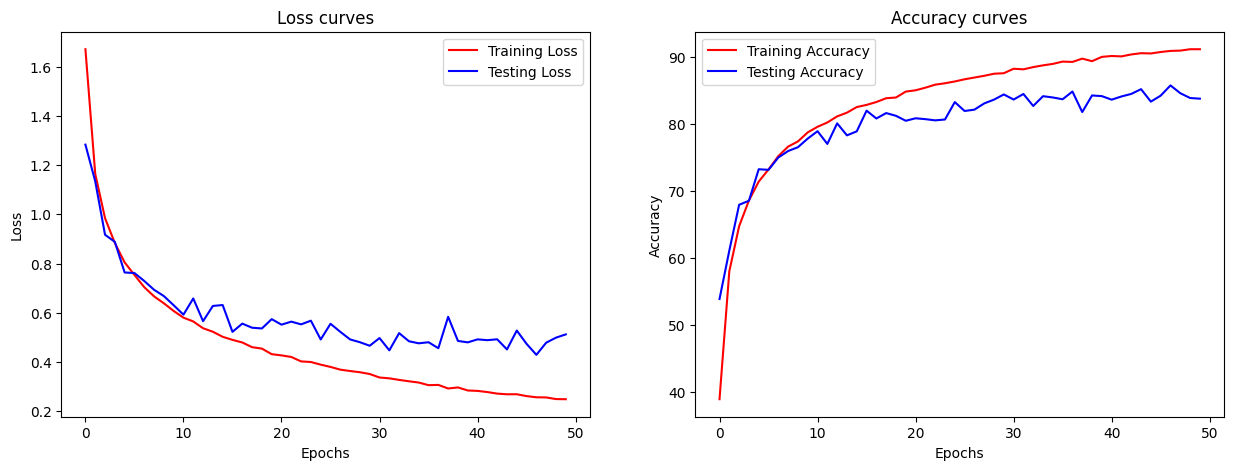

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import ReduceLROnPlateau

#Section 1 Data Preparation and Loading
#preparing by definign transformatiosn for training and testing dat
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(), #randomly flips the image horizontally
    transforms.RandomCrop(32, padding=4), # randomly crops image to 32x32 with padding
    transforms.ToTensor(), # imagine becomes a tensor
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) #normalize tensor
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])
#downloading Data Set
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(testset, batch_size=128, shuffle=False, num_workers=2)

#Section 2 Training/Testing model
class IntermediateBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(IntermediateBlock, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1) #conv layer
        self.bn = nn.BatchNorm2d(out_channels)  # adding batch normalization
        self.fc = nn.Linear(in_channels, out_channels) # fc lauer

    def forward(self, x):
        batch_size, channels, height, width = x.size()
        x_avg = x.view(batch_size, channels, -1).mean(dim=2) #computing average value of each channel
        a = self.fc(x_avg).unsqueeze(2).unsqueeze(3) #vector a being computed
        out = a.expand_as(self.conv(x)) * self.bn(self.conv(x))  # applying batch normalization
        return out

# Adjusted Network Architecture
class Net(nn.Module):
    def __init__(self, num_classes):
        super(Net, self).__init__()
        self.block1 = IntermediateBlock(3, 64) #1st intermediate block
        self.block2 = IntermediateBlock(64, 128) #2nd intermediate block
        self.block3 = IntermediateBlock(128, 256) #3rd intermediate block
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(256 * 4 * 4, 512)
        self.fc2 = nn.Linear(512, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.block1(x)))# applying intermediate block, RelU and max pooling
        x = self.pool(F.relu(self.block2(x)))
        x = self.pool(F.relu(self.block3(x)))
        x = x.view(-1, 256 * 4 * 4) # output being flattened
        x = F.relu(self.fc1(x))  # Removed dropout, applying fc layer and Relu
        x = self.fc2(x) #output layer being applied
        return x

# Section Training/Testing model
num_classes = 10  # Number of output classes

#creating a model instance
net = Net(num_classes)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
net.to(device) #move model to device

#defining hyperparameters
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9, weight_decay=5e-4)
scheduler = ReduceLROnPlateau(optimizer, 'min', patience=5)

def train(net, trainloader, optimizer, criterion, device):
    net.train() #setting model to training mode
    running_loss = 0.0
    correct = 0
    total = 0
    for batch_idx, (inputs, targets) in enumerate(trainloader):
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad() #clear gradients
        outputs = net(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step() #updating weights
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()
    train_loss = running_loss / len(trainloader)
    train_acc = 100. * correct / total
    return train_loss, train_acc

def test(net, testloader, criterion, device):
    net.eval()# setting the model to evaluation mode
    test_loss = 0
    correct = 0
    total = 0
    with torch.no_grad(): #disabling gradient computation
        for batch_idx, (inputs, targets) in enumerate(testloader):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = net(inputs)
            loss = criterion(outputs, targets) #computing loss
            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0) # updating nmber of smaples
            correct += predicted.eq(targets).sum().item() #updating number of correct predictions
    test_loss /= len(testloader) # computing average loss
    test_acc = 100. * correct / total # computing accuracy
    return test_loss, test_acc

# Training loop for all epochs
train_losses = []
test_losses = []
train_accs = []
test_accs = []
best_acc = 0

for epoch in range(50):
    print('\nEpoch: %d' % epoch)
    train_loss, train_acc = train(net, trainloader, optimizer, criterion, device)
    test_loss, test_acc = test(net, testloader, criterion, device)

    train_losses.append(train_loss)
    test_losses.append(test_loss)
    train_accs.append(train_acc)
    test_accs.append(test_acc)

    # Update the best accuracy
    if test_acc > best_acc:
        best_acc = test_acc

    print(f'Train Loss: {train_loss:.3f} | Train Acc: {train_acc:.3f}')
    print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc:.3f}')

print(f'\nBest Test Accuracy: {best_acc:.3f}')

# Section 4: Plotting
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(range(50), train_losses, 'r', label='Training Loss')
plt.plot(range(50), test_losses, 'b', label='Testing Loss')
plt.title('Loss curves')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(50), train_accs, 'r', label='Training Accuracy')
plt.plot(range(50), test_accs, 'b', label='Testing Accuracy')
plt.title('Accuracy curves')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()